# CAB420, Sequences, Additional Example: Sequence Classification
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

**WARNING: This example is not quick. Training of the SVM in particular will take a while.**

Sequences are everywhere, but they need to be handled differently from the tabular data or the sort of image or audio data that we've used so far. The big differences are that:
* sequences can be of different lengths, and 
* sequences often have some inherent ordering going on that ideally, we'd like take notice of and deal with appropriately. 

In this example we'll look at a really simple way to work with sequences by creating a fixed length representation.

This approach is rarely optimal, but it's easy to apply and allows us to use sequeces with all the methods that we've already looked at.


## Too Long; Didn't Read:
* All of the existing classification methods that we've looked at expect a fixed length representation, i.e. all samples are the same size
* Sequences don't always give us this, some of them are different lengths. A really simple way to achieve a fixed length is to pad all sequences to that they are the same length, adding 0's until all sequences are the same length
* This can greatly increase the feature dimensions, and can lead to fairly slow and cumbersome models, which also have to learn how to ignore all the 0's (which they can't always do)

In [21]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

## The Data
Our data comes from the well of human love and kindness that is twitter. We have 160,000 tweets that have been havested. For each of these, the tweet has been classified as either positive or negative.

In [22]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv', header = None)
tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In the name of not running this for a week, we're just going to pull out a sample of the data. You can tweak this sample size to your heart's content. A larger sample is obviously more representitive, but will take longer to run.

In [23]:
tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])

num_samples = 10000
train_samples = 8000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

(8000,)
(8000,)
(2000,)
(2000,)


## Word2Vec

Earlier in semester we classified beer names. We'll take the same approach here:
* Break our inputs into tokens, each word is a token
* Shift all tokens to lower case, and remove punctuation
* Train a Word2ec model on our corpus
* Convert our data to embeddings

Once again, we'll train our own Word2Vec model, though we could just as easily use a pre-trained one here. I would expect to get a small improvement from using a pre-trained model, but the one catch could be that our tweets will contain a lot of out-of-dictionary words depending on what the model is trained on. For example, twitter user names are unlikely to appear in a model trained on classical texts.

In [24]:
# store as list of lists of words
train_X_tokens = []
max_length = 0
for t in train_X:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", t.lower()).split()
    train_X_tokens.append(tokens)
    max_length = max(max_length, len(tokens))

test_X_tokens = []
for t in test_X:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", t.lower()).split()
    test_X_tokens.append(tokens)
    max_length = max(max_length, len(tokens))

# have a look at the results
print(train_X_tokens[1:10])
print(max_length)

[['looking', 'through', 'the', 'pictures', 'from', 'the', 'past', 'few', 'days', 'makes', 'me', 'want', 'to', 'quot', 'accidentally', 'quot', 'miss', 'my', 'flight'], ['feeling', 'pretty', 'nervous', 'got', 'a', 'meeting', 'with', 'my', 'ex', 'classmates', 'whom', 'i', 'haven', 't', 'seen', 'for', 'a', 'few', 'years', 'can', 't', 'believe', 'i', 'signed', 'up', 'to', 'it'], ['give', 'it', 'a', 'try', 'to', 'sleep', 'even', 'the', 'power', 'of', 'night', 'can', 't', 'quench', 'the', 'love', 'i', 'have', 'inside', 'amazing'], ['mskimii', 'he', 's', 'recently', 'set', 'up', 'his', 'own', 'lingerie', 'line'], ['stephietx', 'my', 'tummy', 'hurts', 'i', 'hate', 'having', 'a', 'vagina', 'i', 'wanna', 'rip', 'it', 'off', 'haha', 'cramps'], ['britespark', 'it', 'is', 'getting', 'desperate', 'now', 'i', 'must', 'admit'], ['anybody', 'wanna', 'bring', 'me', 'a', 'sausage', 'mcmuffin', 'this', 'morning', 'c', 'mon', 'you', 'know', 'you', 'want', 'to'], ['i64', 'will', 'be', 'a', 'long', 'day'], ['

In [25]:
# train the model
embedding_size = 100
word_model = Word2Vec(sentences=train_X_tokens, vector_size=embedding_size, window=5, min_count=3, workers=4, sg=0)

At this point, we can convert our tokens to embeddings. One things we need to remember is that we need to get all of our features into the same size. As such, we'll set our feature size to fit the longest tweet, and everything else will get padded with zeros.

One other thing we need to do is check for out of dictionary words (i.e. words our word2vec model doesn't know). When we find such words, we'll just skip them and leave 0's in it's place.

In [26]:
train_X_embeddings = []
for i,n in enumerate(train_X_tokens):    
    v = numpy.zeros(embedding_size*max_length)
    for j,w in enumerate(n):
        if (word_model.wv.has_index_for(w)):
            v[j*embedding_size:(j+1)*embedding_size] = word_model.wv[w]
    train_X_embeddings.append(v)

test_X_embeddings = []
for i,n in enumerate(test_X_tokens):    
    v = numpy.zeros(embedding_size*max_length)
    for j,w in enumerate(n):
        if (word_model.wv.has_index_for(w)):
            v[j*embedding_size:(j+1)*embedding_size] = word_model.wv[w]
    test_X_embeddings.append(v)

At this point, we have data. We've gone from upto 140 characters to vectors of length $3800$, and that's only because we limited our word2vec model to learning embeddings of size 100. Typical emebeddings are of size $300$.

## Model Training

We'll keep it simple here, and just train three smple classifiers:
* A CKNN
* An SVM
* A Random Forest

In all cases we'll use fairly standard parameters and we won't try to optimise the models. This is something you can do in your own time.

The eval_model function that has followed us through numerous examples and pracs will also make a return.

In [27]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))    

### CKNN

We have a lot of data, so there's no need to use a small value of K. We've also previously seen that using a weighted based on the inverse of the distance is usually good, so we'll do that here.

Beyond this, there is no optimisation. You are encouraged to explore this in your own time.

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       994
           4       0.58      0.61      0.59      1006

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



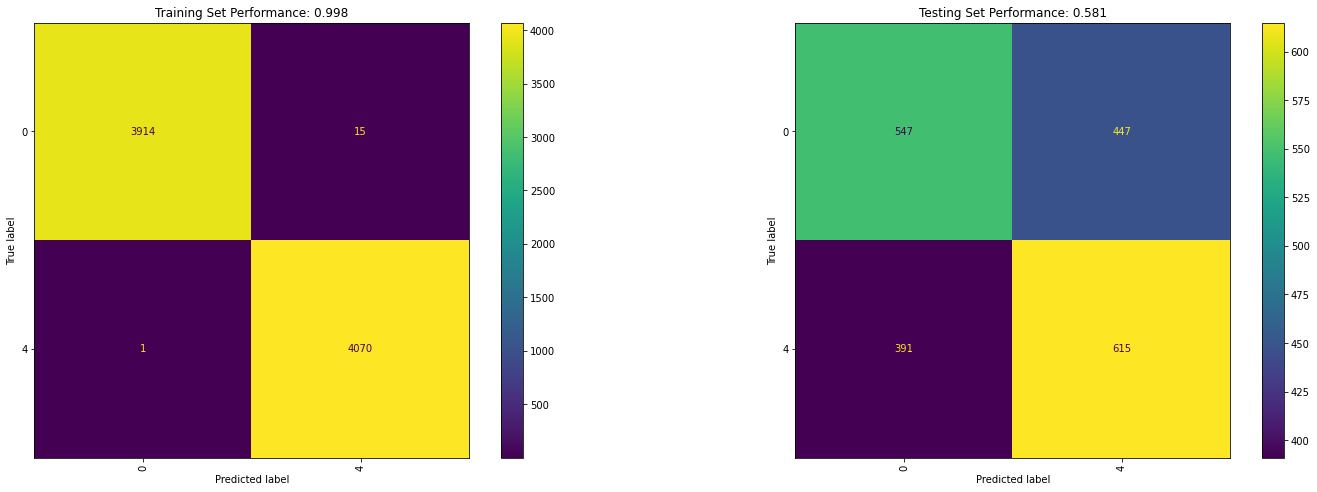

In [28]:
cknn = KNeighborsClassifier(n_neighbors=100, weights='distance')
cknn.fit(train_X_embeddings, train_Y)
eval_model(cknn, train_X_embeddings, train_Y, test_X_embeddings, test_Y)

### SVM

We have a high dimensional, sparse feature vector. In general, this isn't a bad thing for an SVM. We'll use with a linear SVM and $C=1$, i.e. the defaults.

              precision    recall  f1-score   support

           0       0.62      0.56      0.59       994
           4       0.60      0.66      0.63      1006

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



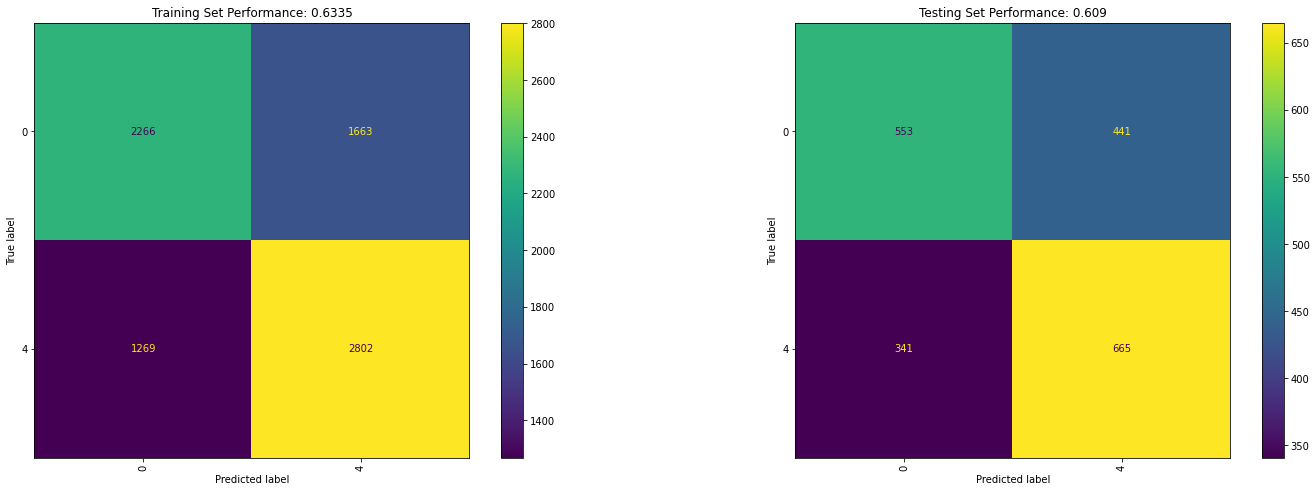

In [29]:
svm = SVC()
svm.fit(train_X_embeddings, train_Y)
eval_model(svm, train_X_embeddings, train_Y, test_X_embeddings, test_Y)

### Random Forest

Finally, we'll throw a random forest at this. We have quite large feature vectors, so we can't use trees that are too shallow, and the 15 we have here could be increased further if you so wish.

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       994
           4       0.63      0.70      0.66      1006

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



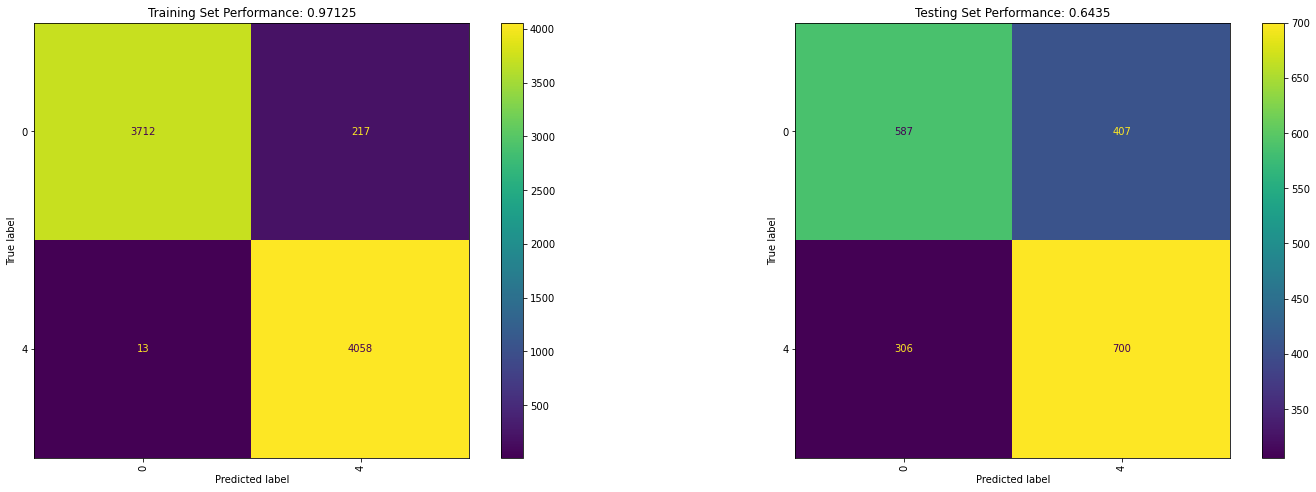

In [30]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf.fit(train_X_embeddings, train_Y)
eval_model(rf, train_X_embeddings, train_Y, test_X_embeddings, test_Y)

## Model Performance

None of our models are terrible, yet none are spectacular. Our dataset is quite balanced and large, so our usual problems (class imbalance, small datasets) shouldn't apply here. Or should they?

While it may seem odd to suggest it, we perhaps do have an issue with data scarcity here. We do have a lot of training samples, but we also have $3800$ dimension features, so more data would help us here - but would lead to an increase in run-time. One other problem we have is that our models are all reliant on the order of the data. For example, let's say we have two tweets:
* This is a positive tweet
* Positive tweet, this is

(The second should be said in your best Yoda voice). Both are tweets with a positive sentiment, both contain almost the exact same words (and in all likelihood, both "a" and "is" would be dropped for being short words), yet both would obtain totally different feature vectors. Let's pretend that we have a 1D embedding (i.e. 1 number) and our word2vec model encodes "this" as 1, "is" as 2, "positive" as 3, and "tweet" as 4. "a" is a short word and so is ignored. This means that our tweets become:
* This is a positive tweet -> [1, 2, 3, 4]
* Positive tweet, this is -> [3, 4, 1, 2]

Same words, same sentiment, very different feature vectors. Let's now consider a tweet, "Negative tweet, this is". Our word2vec model encodes "negative" as 5, so we get the feature vector [5, 4, 1, 2]. Considering our three tweets, the two "Yoda" style ones are the most similar in our feature space, despite being different sentiments. 

This strong focus on ordering is, in this case, not desireable as the words that dictate a tweet's sentiment can be distributed anywhere in the tweet. This doesn't mean that relying on alignment like this is always bad, consider a different example where you have videos of a door opening, and the same door closing. The only way to tell one from the other is by looking at the order of the data and how the two sequneces align; but whether this is important or not depends on the task.

Finally, it's also important to note that we've not tuned these classifiers. As we've seen in previous weeks, there are a lot of dials to adjust on these models, and this would give us a performance gain.

## Final Thoughts

This has shown a simple way to train a model to operate on sequential data, but this approach has some drawbacks:
* Our approach for getting data into a consistent length is to just pad it. This makes our features very large.
* As part of the large features, our method is far from quick.
* Our method is mixed when considering ordering. It forces a very strict alignment of features, the first word is always comapred with other first words in feature space; but there's also no knowledge of how the words relate to one another. Essentially, although each dimension very carefully and consistently ordered, each dimensions is also independant and so we're not really exploiting the fact that we have a sequence.

Our approach for getting sequences of fixed length here is not great, but this method is actually very common. There are a number of other approaches, including:
* Resampling the sequence
* Warping the sequence with a method such as Dynamic Time Warping

Both these methods work well for signals (audio, video, etc), where you can effectivley slow down or speed up bits of the sequence. Such methods don't really work for text sadly, so we're stuck with padding. For other sequences where you have the ability to use these, fixed length machine learning approaches tend to make a bit more sense.